In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str})
print(train_set_orig.shape)
train_set_orig.head()

(588758, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str})
print(test_set.shape)
test_set.head()

(32995, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,0.008458,2
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,0.050831,2


Only include articles bought after 2020-01:

In [9]:
# Prop. with single transaction
(train_set_orig.groupby('customer_id')['article_id'].count() == 1).mean()

0.016507384882710686

In [10]:
train_set_orig['total_purchases'] = train_set_orig.groupby('customer_id')['article_id'].transform("count")

In [11]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [12]:
# article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-01-01']['article_id'].unique()
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2017-01-01']['article_id'].unique()

In [13]:
# Map other article_ids to a single value
OTHER_ARTICLE_ID = '000'

train_set_orig['article_id'] = np.where(
    train_set_orig['article_id'].isin(article_id_to_keep),
    train_set_orig['article_id'],
    OTHER_ARTICLE_ID
)

In [14]:
train_set_orig.sort_values(['customer_id', 't_dat'], inplace=True)

In [15]:
train_set_orig['last_article_id'] = train_set_orig.groupby('customer_id')['article_id'].shift(1)

- Drop cases where `article_id` == `OTHER_ARTICLE_ID`
- Drop customers with only a single purchase (we can just predict top-12 for these)
- Fill null `last_article_id` with `FIRST_ARTICLE_ID` (first transaction)

In [16]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'] != OTHER_ARTICLE_ID]
print(train_set_orig.shape)

(588758, 7)
(588758, 7)


In [17]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['total_purchases'] != 1]
train_set_orig.drop(columns='total_purchases', inplace=True)
print(train_set_orig.shape)

(588758, 7)
(588606, 6)


In [18]:
FIRST_ARTICLE_ID = '111'

train_set_orig['last_article_id'].fillna(FIRST_ARTICLE_ID, inplace=True)

In [19]:
print(train_set_orig.shape)
train_set_orig.head()

(588606, 6)


,t_dat,customer_id,article_id,price,sales_channel_id,last_article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,111
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0663713001
2788,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0541518023
109623,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0.013542,2,0663713001
383502,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0.025407,2,0578020002


In [20]:
print((train_set_orig['last_article_id'] == OTHER_ARTICLE_ID).mean())
print((train_set_orig['last_article_id'] == FIRST_ARTICLE_ID).mean())

0.0
0.015385504055344322


In [21]:
train_set_orig['t_dat'].min()

Timestamp('2018-09-20 00:00:00')

#### Load customer features

In [22]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [23]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [24]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [25]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [26]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [27]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [28]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


### Map `customer_id` and `article_id` to indices

In [29]:
customer_id_to_idx = {cust_id: idx for idx, cust_id in enumerate(set(train_set_orig['customer_id']).union(test_set['customer_id']))}

len(customer_id_to_idx)

9208

In [30]:
article_id_to_idx = {art_id: idx + 2 for idx, art_id in enumerate(article_id_to_keep)}
article_id_to_idx[OTHER_ARTICLE_ID] = 0
article_id_to_idx[FIRST_ARTICLE_ID] = 1

len(article_id_to_idx)

61494

In [31]:
train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,last_article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,111
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0663713001
2788,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0541518023
109623,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0.013542,2,0663713001
383502,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0.025407,2,0578020002


In [32]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)

In [33]:
train_set_orig.rename(columns={'article_id': 'label', 'last_article_id': 'article_id'}, inplace=True)

In [34]:
train_set_orig['label_idx'] = train_set_orig['label'].map(article_id_to_idx)
train_set_orig['article_id_idx'] = train_set_orig['article_id'].map(article_id_to_idx)

In [35]:
train_set_orig.isnull().sum()

t_dat               0
customer_id         0
label               0
price               0
sales_channel_id    0
article_id          0
customer_id_idx     0
label_idx           0
article_id_idx      0
dtype: int64

In [36]:
train_set_orig.head()

,t_dat,customer_id,label,price,sales_channel_id,article_id,customer_id_idx,label_idx,article_id_idx
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,111,795,2,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0663713001,795,3,2
2788,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0541518023,795,2,3
109623,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0.013542,2,0663713001,795,7978,2
383502,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0.025407,2,0578020002,795,16370,7978


#### Load articles features

In [37]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
)

print(articles_df.shape)
articles_df = articles_df.copy()[articles_df['article_id'].isin(article_id_to_keep)]
print(articles_df.shape)
articles_df.head()

(105542, 25)
(61492, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [38]:
articles_df['product_group_no'] = articles_df['product_group_name'].copy()

In [39]:
CATEGORICAL_FEATURES = [
    'product_code', 
    'product_type_no', 
    'product_group_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id', 
    'perceived_colour_master_id', 
    'department_no', 
    'index_code', 
    'index_group_no', 
    'section_no', 
    'garment_group_no'
]

In [40]:
cat_code_to_indices = {}

for cat in CATEGORICAL_FEATURES:
    cat_code_to_indices[cat] = {v: k+2 for k, v in enumerate(articles_df[cat].unique())}

In [41]:
for cat in CATEGORICAL_FEATURES:
    articles_df[cat] = articles_df[cat].map(cat_code_to_indices[cat])

In [42]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0108775015,2,Strap top,2,Vest top,Garment Upper body,2,Solid,2,Black,2,Dark,2,Black,2,Jersey Basic,2,Ladieswear,2,Ladieswear,2,Womens Everyday Basics,2,Jersey Basic,Jersey top with narrow shoulder straps.,2
1,0108775044,2,Strap top,2,Vest top,Garment Upper body,2,Solid,3,White,3,Light,3,White,2,Jersey Basic,2,Ladieswear,2,Ladieswear,2,Womens Everyday Basics,2,Jersey Basic,Jersey top with narrow shoulder straps.,2
2,0108775051,2,Strap top (1),2,Vest top,Garment Upper body,3,Stripe,4,Off White,4,Dusty Light,3,White,2,Jersey Basic,2,Ladieswear,2,Ladieswear,2,Womens Everyday Basics,2,Jersey Basic,Jersey top with narrow shoulder straps.,2
3,0110065001,3,OP T-shirt (Idro),3,Bra,Underwear,2,Solid,2,Black,2,Dark,2,Black,3,Clean Lingerie,3,Lingeries/Tights,2,Ladieswear,3,Womens Lingerie,3,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",3
4,0110065002,3,OP T-shirt (Idro),3,Bra,Underwear,2,Solid,3,White,3,Light,3,White,3,Clean Lingerie,3,Lingeries/Tights,2,Ladieswear,3,Womens Lingerie,3,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",3


In [43]:
articles_df['article_id_idx'] = articles_df['article_id'].map(article_id_to_idx)

In [44]:
articles_df['article_id_idx'].isnull().sum()

0

In [45]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [46]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [47]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [48]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [49]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,795.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


Merge article features

In [50]:
train_set_orig.shape

(588606, 9)

In [51]:
train_set_orig = train_set_orig.merge(
    articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], 
    on='article_id_idx', 
    how='left'
)

In [52]:
print(train_set_orig.shape)
train_set_orig.head()

(588606, 21)


,t_dat,customer_id,label,price,sales_channel_id,article_id,customer_id_idx,label_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,111,795,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0663713001,795,3,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0
2,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0541518023,795,2,3,1679.0,3.0,3.0,2.0,19.0,4.0,7.0,5.0,3.0,2.0,3.0,3.0
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0.013542,2,0663713001,795,7978,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0.025407,2,0578020002,795,16370,7978,2970.0,60.0,2.0,3.0,28.0,3.0,6.0,144.0,2.0,2.0,37.0,19.0


In [53]:
train_set_orig.isnull().sum()

t_dat                            0
customer_id                      0
label                            0
price                            0
sales_channel_id                 0
article_id                       0
customer_id_idx                  0
label_idx                        0
article_id_idx                   0
product_code                  9056
product_type_no               9056
product_group_no              9056
graphical_appearance_no       9056
colour_group_code             9056
perceived_colour_value_id     9056
perceived_colour_master_id    9056
department_no                 9056
index_code                    9056
index_group_no                9056
section_no                    9056
garment_group_no              9056
dtype: int64

In [54]:
for cat in CATEGORICAL_FEATURES:

    train_set_orig[cat] = np.where(
        train_set_orig['article_id_idx'] == 0,
        0,
        train_set_orig[cat]
    )

    train_set_orig[cat] = np.where(
        train_set_orig['article_id_idx'] == 1,
        1,
        train_set_orig[cat]
    )

In [55]:
train_set_orig.drop(columns=['price', 'sales_channel_id'], inplace=True)

Merge customer features

In [56]:
train_set_orig.shape

(588606, 19)

In [57]:
train_set_orig = train_set_orig.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

In [58]:
print(train_set_orig.shape)
train_set_orig.head()

(588606, 25)


,t_dat,customer_id,label,article_id,customer_id_idx,label_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,111,795,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,0,24.0,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0663713001,795,3,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2
2,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0541518023,795,2,3,1679.0,3.0,3.0,2.0,19.0,4.0,7.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0663713001,795,7978,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0578020002,795,16370,7978,2970.0,60.0,2.0,3.0,28.0,3.0,6.0,144.0,2.0,2.0,37.0,19.0,0.0,0.0,0,0,24.0,2


### Create example age and time-related features

In [59]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [60]:
train_set_orig['example_age'] = (end - train_set_orig['t_dat']).dt.days

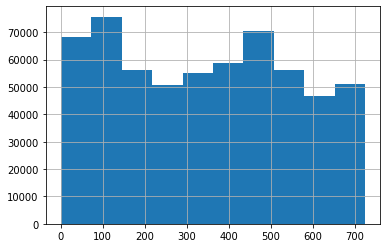

In [61]:
train_set_orig['example_age'].hist()

In [62]:
train_set_orig['t_dat_quarter'] = train_set_orig['t_dat'].dt.quarter

In [63]:
train_set_orig = pd.get_dummies(train_set_orig, columns=['t_dat_quarter'])

In [64]:
train_set_orig.head()

,t_dat,customer_id,label,article_id,customer_id_idx,label_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,111,795,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,0,24.0,2,725,0,0,1,0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0663713001,795,3,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2,725,0,0,1,0
2,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0541518023,795,2,3,1679.0,3.0,3.0,2.0,19.0,4.0,7.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2,721,0,0,1,0
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0578020002,0663713001,795,7978,2,8215.0,62.0,3.0,2.0,2.0,2.0,2.0,44.0,3.0,2.0,3.0,3.0,0.0,0.0,0,0,24.0,2,563,1,0,0,0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0578020002,795,16370,7978,2970.0,60.0,2.0,3.0,28.0,3.0,6.0,144.0,2.0,2.0,37.0,19.0,0.0,0.0,0,0,24.0,2,224,1,0,0,0


### Create development set

In [65]:
# # Latest transactions only
train_set_orig = train_set_orig.copy()[train_set_orig['t_dat'] > end - datetime.timedelta(days=7*6)]

In [66]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.shape, dev_set.shape

((31827, 30), (8352, 30))

In [67]:
# # Selected months only
# train_set_orig = train_set_orig.copy()[train_set_orig['t_dat'].dt.month.isin([5, 6, 7, 8, 9])]

### Format data

Since all the users in the test said are included in training we utilise the full training set.

In [68]:
train_set.head()

,t_dat,customer_id,label,article_id,customer_id_idx,label_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
359,2020-08-04,00639e775b90554156986100685c4d408723c77e411e37...,0886241001,0886241003,2528,54307,53201,28199.0,46.0,12.0,3.0,28.0,3.0,6.0,45.0,2.0,2.0,23.0,11.0,1.0,1.0,0,1,25.0,1884,41,0,0,1,0
360,2020-08-07,00639e775b90554156986100685c4d408723c77e411e37...,0841238002,0886241001,2528,55142,54307,28199.0,46.0,12.0,2.0,3.0,3.0,3.0,45.0,2.0,2.0,23.0,11.0,1.0,1.0,0,1,25.0,1884,38,0,0,1,0
529,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0810419002,0805510026,761,44035,50958,21630.0,25.0,2.0,21.0,3.0,3.0,3.0,194.0,2.0,2.0,37.0,5.0,1.0,1.0,0,1,32.0,1886,32,0,0,1,0
530,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0810419002,0810419002,761,44035,44035,22124.0,35.0,10.0,3.0,3.0,3.0,3.0,22.0,3.0,2.0,15.0,9.0,1.0,1.0,0,1,32.0,1886,32,0,0,1,0
531,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0898256001,0810419002,761,53275,44035,22124.0,35.0,10.0,3.0,3.0,3.0,3.0,22.0,3.0,2.0,15.0,9.0,1.0,1.0,0,1,32.0,1886,32,0,0,1,0


In [69]:
endm1

Timestamp('2020-09-07 00:00:00')

In [70]:
train_set.shape

(31827, 30)

In [71]:
from sklearn.impute import SimpleImputer

In [72]:
imp_mean = SimpleImputer()

In [73]:
imp_mean.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [74]:
train_set['age'] = imp_mean.transform(train_set['age'].values.reshape(-1, 1))
dev_set['age'] = imp_mean.transform(dev_set['age'].values.reshape(-1, 1))

In [75]:
from sklearn.preprocessing import MinMaxScaler

In [76]:
age_scaler = MinMaxScaler()

In [77]:
age_scaler.fit(train_set['age'].values.reshape(-1, 1))

MinMaxScaler()

In [78]:
example_age_scalar = MinMaxScaler()

In [79]:
example_age_scalar.fit(train_set.append(dev_set)['example_age'].values.reshape(-1, 1))

MinMaxScaler()

In [80]:
train_set['age'] = age_scaler.transform(train_set['age'].values.reshape(-1, 1))
dev_set['age'] = age_scaler.transform(dev_set['age'].values.reshape(-1, 1))

In [81]:
train_set['example_age'] = example_age_scalar.transform(train_set['example_age'].values.reshape(-1, 1))
dev_set['example_age'] = example_age_scalar.transform(dev_set['example_age'].values.reshape(-1, 1))

In [82]:
train_set.head()

,t_dat,customer_id,label,article_id,customer_id_idx,label_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
359,2020-08-04,00639e775b90554156986100685c4d408723c77e411e37...,0886241001,0886241003,2528,54307,53201,28199.0,46.0,12.0,3.0,28.0,3.0,6.0,45.0,2.0,2.0,23.0,11.0,1.0,1.0,0,1,0.123077,1884,1.000000,0,0,1,0
360,2020-08-07,00639e775b90554156986100685c4d408723c77e411e37...,0841238002,0886241001,2528,55142,54307,28199.0,46.0,12.0,2.0,3.0,3.0,3.0,45.0,2.0,2.0,23.0,11.0,1.0,1.0,0,1,0.123077,1884,0.926829,0,0,1,0
529,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0810419002,0805510026,761,44035,50958,21630.0,25.0,2.0,21.0,3.0,3.0,3.0,194.0,2.0,2.0,37.0,5.0,1.0,1.0,0,1,0.230769,1886,0.780488,0,0,1,0
530,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0810419002,0810419002,761,44035,44035,22124.0,35.0,10.0,3.0,3.0,3.0,3.0,22.0,3.0,2.0,15.0,9.0,1.0,1.0,0,1,0.230769,1886,0.780488,0,0,1,0
531,2020-08-13,0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a...,0898256001,0810419002,761,53275,44035,22124.0,35.0,10.0,3.0,3.0,3.0,3.0,22.0,3.0,2.0,15.0,9.0,1.0,1.0,0,1,0.230769,1886,0.780488,0,0,1,0


In [83]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age', 
    'example_age', 
    't_dat_quarter_1', 
    't_dat_quarter_2', 
    't_dat_quarter_3', 
    't_dat_quarter_4'
]

In [84]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values.astype(int)
        self.article_id_idx = df['article_id_idx'].values.astype(int)
        self.product_code = df['product_code'].values.astype(int)
        self.product_type_no = df['product_type_no'].values.astype(int)
        self.product_group_no = df['product_group_no'].values.astype(int)
        self.graphical_appearance_no = df['graphical_appearance_no'].values.astype(int)
        self.colour_group_code = df['colour_group_code'].values.astype(int)
        self.perceived_colour_value_id = df['perceived_colour_value_id'].values.astype(int)
        self.perceived_colour_master_id = df['perceived_colour_master_id'].values.astype(int)
        self.department_no = df['department_no'].values.astype(int)
        self.index_code = df['index_code'].values.astype(int)
        self.index_group_no = df['index_group_no'].values.astype(int)
        self.section_no = df['section_no'].values.astype(int)
        self.garment_group_no = df['garment_group_no'].values.astype(int)
        
        self.club_member_status = df['club_member_status'].values.astype(int)
        self.fashion_news_frequency = df['fashion_news_frequency'].values.astype(int)
        self.postal_code = df['postal_code'].values.astype(int)
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['label_idx'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            self.product_code[idx],
            self.product_type_no[idx],
            self.product_group_no[idx],
            self.graphical_appearance_no[idx],
            self.colour_group_code[idx],
            self.perceived_colour_value_id[idx],
            self.perceived_colour_master_id[idx],
            self.department_no[idx],
            self.index_code[idx],
            self.index_group_no[idx],
            self.section_no[idx],
            self.garment_group_no[idx],
            self.club_member_status[idx],
            self.fashion_news_frequency[idx],
            self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [85]:
print((train_set['article_id'] == OTHER_ARTICLE_ID).mean())
print((train_set['article_id'] == FIRST_ARTICLE_ID).mean())

0.0
0.003487604863794891


In [86]:
print((dev_set['article_id'] == OTHER_ARTICLE_ID).mean())
print((dev_set['article_id'] == FIRST_ARTICLE_ID).mean())

0.0
0.005866858237547893


In [87]:
# df_t = train_set[train_set['article_id'] != OTHER_ARTICLE_ID].append(
#     train_set[train_set['article_id'] == OTHER_ARTICLE_ID].sample(n=1000)
# )

In [88]:
# print((df_t['article_id'] == OTHER_ARTICLE_ID).mean())
# print((df_t['article_id'] == FIRST_ARTICLE_ID).mean())

In [89]:
train_dataset = PurchasesDatasetWithArticleFeatures(train_set)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_set)

In [90]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [91]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [92]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=256)        
        self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=256)
        self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code'])+2, embedding_dim=embedding_dim)
        self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no'])+2, embedding_dim=embedding_dim)
        self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no'])+2, embedding_dim=embedding_dim)
        self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no'])+2, embedding_dim=embedding_dim)
        self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code'])+2, embedding_dim=embedding_dim)
        self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id'])+2, embedding_dim=embedding_dim)
        self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id'])+2, embedding_dim=embedding_dim)
        self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no'])+2, embedding_dim=embedding_dim)
        self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code'])+2, embedding_dim=embedding_dim)
        self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no'])+2, embedding_dim=embedding_dim)
        self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no'])+2, embedding_dim=embedding_dim)
        self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no'])+2, embedding_dim=embedding_dim)
        
        self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=embedding_dim*15+len(NUMERIC_FEATURES)+256*2, out_features=1024)            
        self.fc_2 = nn.Linear(in_features=1024, out_features=1024)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(article_id_to_idx))
        
        # Activation functions
        self.tanh = nn.Tanh()        
        
        # Dropout
        self.dropout = nn.Dropout(0.4)
        
    def forward(
        self, 
        user_id, 
        item_id,
        product_code, 
        product_type_no, 
        product_group_no, 
        graphical_appearance_no, 
        colour_group_code, 
        perceived_colour_value_id, 
        perceived_colour_master_id, 
        department_no, 
        index_code, 
        index_group_no, 
        section_no, 
        garment_group_no,
        club_member_status,
        fashion_news_frequency,
        postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        product_code_emb = self.product_code_embeddings(product_code)
        product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        department_no_emb = self.department_no_embeddings(department_no)
        index_code_emb = self.index_code_embeddings(index_code)
        index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        section_no_emb = self.section_no_embeddings(section_no)
        garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                product_code_emb,
                product_type_no_emb,
                product_group_no_emb,
                graphical_appearance_no_emb,
                colour_group_code_emb,
                perceived_colour_value_id_emb,
                perceived_colour_master_id_emb,
                department_no_emb,
                index_code_emb,
                index_group_no_emb,
                section_no_emb,
                garment_group_no_emb,
                club_member_status_emb,
                fashion_news_frequency_emb,
                postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.tanh(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.tanh(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        x = self.tanh(x)

        return x

In [93]:
fashion_rec_v2 = FashionRecV2(embedding_dim=128)

In [94]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 256)
  (item_embeddings): Embedding(61494, 256)
  (product_code_embeddings): Embedding(30206, 128)
  (product_type_no_embeddings): Embedding(124, 128)
  (product_group_no_embeddings): Embedding(20, 128)
  (graphical_appearance_no_embeddings): Embedding(32, 128)
  (colour_group_code_embeddings): Embedding(52, 128)
  (perceived_colour_value_id_embeddings): Embedding(10, 128)
  (perceived_colour_master_id_embeddings): Embedding(22, 128)
  (department_no_embeddings): Embedding(296, 128)
  (index_code_embeddings): Embedding(12, 128)
  (index_group_no_embeddings): Embedding(7, 128)
  (section_no_embeddings): Embedding(59, 128)
  (garment_group_no_embeddings): Embedding(23, 128)
  (club_member_status_embeddings): Embedding(4, 128)
  (fashion_news_frequency_embeddings): Embedding(3, 128)
  (postal_code_embeddings): Embedding(352899, 128)
  (fc_1): Linear(in_features=2440, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_fea

In [95]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [96]:
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.00001)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [97]:
criterion = nn.CrossEntropyLoss()

In [98]:
MAX_EPOCHS = 10
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )

        loss = criterion(pred, label)

        loss.backward()  
        
        optimizer.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data            

            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.CrossEntropyLoss(reduction='sum')(pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.CrossEntropyLoss(reduction='sum')(pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

100%|██████████| 63/63 [00:01<00:00, 57.51it/s]


Training loss: 10.857843178090977


100%|██████████| 17/17 [00:00<00:00, 54.59it/s]


Dev loss: 10.916838371890714


100%|██████████| 63/63 [00:01<00:00, 53.88it/s]


Training loss: 10.256953936500825


100%|██████████| 17/17 [00:00<00:00, 55.58it/s]


Dev loss: 10.527787745684043


100%|██████████| 63/63 [00:01<00:00, 55.80it/s]


Training loss: 10.150822304853804


100%|██████████| 17/17 [00:00<00:00, 56.54it/s]


Dev loss: 10.46037044013597


100%|██████████| 63/63 [00:01<00:00, 44.52it/s]


Training loss: 10.07709323220126


100%|██████████| 17/17 [00:00<00:00, 56.17it/s]


Dev loss: 10.414410777475641


100%|██████████| 63/63 [00:01<00:00, 56.69it/s]


Training loss: 10.020532240370057


100%|██████████| 17/17 [00:00<00:00, 55.59it/s]


Dev loss: 10.37982475894621


100%|██████████| 63/63 [00:01<00:00, 57.13it/s]


Training loss: 9.976428359581194


100%|██████████| 17/17 [00:00<00:00, 54.95it/s]


Dev loss: 10.353606227713984


100%|██████████| 63/63 [00:01<00:00, 56.29it/s]


Training loss: 9.941445520994115


100%|██████████| 17/17 [00:00<00:00, 56.75it/s]


Dev loss: 10.333631055108432


100%|██████████| 63/63 [00:01<00:00, 56.65it/s]


Training loss: 9.91276186646018


100%|██████████| 17/17 [00:00<00:00, 56.64it/s]


Dev loss: 10.318040095069856


100%|██████████| 63/63 [00:01<00:00, 56.68it/s]


Training loss: 9.889120338706745


100%|██████████| 17/17 [00:00<00:00, 56.48it/s]


Dev loss: 10.305329976867442


100%|██████████| 63/63 [00:01<00:00, 56.63it/s]


Training loss: 9.869350804787283


100%|██████████| 17/17 [00:00<00:00, 55.92it/s]

Dev loss: 10.29550797911896


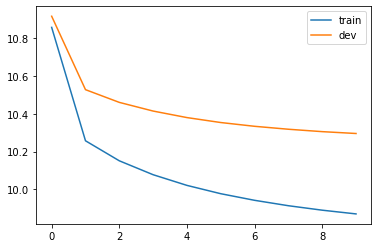

In [99]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Test set evaluation

In [100]:
test_set.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,0.008458,2
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,0.050831,2


In [101]:
historical_trans = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str})
historical_trans['t_dat'] = pd.to_datetime(historical_trans['t_dat'])
historical_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2


In [102]:
historical_trans.sort_values(['customer_id', 't_dat'], inplace=True)

In [103]:
historical_trans = historical_trans.groupby('customer_id').tail(1)[['customer_id', 'article_id']]
historical_trans.head()

,customer_id,article_id
441810,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0852643003
504339,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0827411001
545881,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,0790686007
21473,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,0628326001
582225,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0903924001


In [104]:
test_set.shape[0]

32995

In [105]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

In [106]:
test_set['article_id_idx'].isnull().sum()

4547

In [107]:
test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[59349.0]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[61431.0, 61431.0, 58340.0, 60439.0, 61055.0, ..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[51593.0, 51305.0]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[59512.0, 11893.0, 11893.0, 58663.0, nan, nan,..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[45876.0, 61138.0, 204.0, 39707.0, 59279.0, na..."


In [108]:
test_set.shape

(32995, 6)

In [109]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.head()

,customer_id,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,795
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,4960
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,5681
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,2205
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,1792


In [110]:
test_data = test_data.merge(historical_trans, on='customer_id', how='left')
test_data.shape

(9208, 3)

In [111]:
test_data['article_id_idx'] = test_data['article_id'].map(article_id_to_idx)

In [112]:
test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'], how='left')

In [113]:
test_data.shape

(9208, 16)

In [114]:
test_data = test_data.merge(customers.drop(columns=['customer_id_idx']), on='customer_id')

In [115]:
set(train_set.columns) - set(test_data.columns)

{'example_age',
 'label',
 'label_idx',
 't_dat',
 't_dat_quarter_1',
 't_dat_quarter_2',
 't_dat_quarter_3',
 't_dat_quarter_4'}

In [116]:
pd.to_datetime(test_set['t_dat']).dt.quarter.unique()

array([3])

In [117]:
dev_set['example_age'].min()

0.0

In [118]:
test_data['example_age'] = 0
test_data['label'] = 999
test_data['label_idx'] = 999
test_data['t_dat'] = 999
test_data['t_dat_quarter_1'] = 0
test_data['t_dat_quarter_2'] = 0
test_data['t_dat_quarter_3'] = 1
test_data['t_dat_quarter_4'] = 0

In [119]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

In [120]:
len(test_dataset)

9208

In [121]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [122]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )
        
        test_predictions += torch.topk(pred, 1000, dim=1).indices.tolist()

100%|██████████| 18/18 [00:00<00:00, 18.77it/s]


In [123]:
len(test_predictions)

9208

In [124]:
len(test_data)

9208

In [125]:
test_data['predictions'] = test_predictions

In [126]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

In [127]:
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[59349.0],795
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[61431.0, 61431.0, 58340.0, 60439.0, 61055.0, ...",4960
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[51593.0, 51305.0]",5681
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[59512.0, 11893.0, 11893.0, 58663.0, nan, nan,...",2205
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[45876.0, 61138.0, 204.0, 39707.0, 59279.0, na...",1792


In [128]:
test_set_by_customer = test_set_by_customer.merge(test_data[['customer_id_idx', 'predictions']], on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[59349.0],795,"[58568, 58759, 59893, 59459, 31552, 58925, 593..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[61431.0, 61431.0, 58340.0, 60439.0, 61055.0, ...",4960,"[58568, 58759, 31552, 59459, 59893, 58925, 580..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[51593.0, 51305.0]",5681,"[58568, 58759, 59893, 59459, 31552, 58629, 593..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[59512.0, 11893.0, 11893.0, 58663.0, nan, nan,...",2205,"[58568, 58759, 59893, 31552, 59459, 59308, 589..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[45876.0, 61138.0, 204.0, 39707.0, 59279.0, na...",1792,"[58568, 58759, 59459, 59893, 31552, 58925, 580..."


In [129]:
predictions = test_set_by_customer['predictions'].to_list()

In [130]:
actuals = test_set_by_customer['article_id_idx'].to_list()

In [131]:
mapk(actuals, predictions, k=12)

0.00324988894083509

In [132]:
test_set_by_customer['predictions'].astype(str).nunique()

9172

In [133]:
test_set_by_customer['predictions'].astype(str).value_counts()

[999, 998, 996, 997, 993, 992, 994, 995, 963, 962, 960, 961, 965, 964, 966, 967, 983, 982, 980, 981, 977, 976, 978, 979, 987, 986, 984, 985, 989, 988, 990, 991, 975, 974, 972, 973, 969, 968, 970, 971, 931, 930, 928, 929, 933, 932, 934, 935, 951, 950, 948, 949, 945, 944, 946, 947, 955, 954, 952, 953, 957, 956, 958, 959, 927, 926, 924, 925, 921, 920, 922, 923, 915, 914, 912, 913, 917, 916, 918, 919, 903, 902, 900, 901, 897, 896, 898, 899, 907, 906, 904, 905, 909, 908, 910, 911, 943, 942, 940, 941, 937, 936, 938, 939, 867, 866, 864, 865, 869, 868, 870, 871, 887, 886, 884, 885, 881, 880, 882, 883, 891, 890, 888, 889, 893, 892, 894, 895, 831, 830, 828, 829, 825, 824, 826, 827, 819, 818, 816, 817, 821, 820, 822, 823, 807, 806, 804, 805, 801, 800, 802, 803, 811, 810, 808, 809, 813, 812, 814, 815, 783, 782, 780, 781, 777, 776, 778, 779, 771, 770, 768, 769, 773, 772, 774, 775, 791, 790, 788, 789, 785, 784, 786, 787, 795, 794, 792, 793, 797, 796, 798, 799, 863, 862, 860, 861, 857, 856, 858, 859,

In [134]:
test_set_by_customer.shape

(9208, 4)

In [135]:
most_pop_12 = (train_set.groupby('article_id_idx')['customer_id'].count()).sort_values(ascending=False).head(12).index.to_list()
most_pop_12 = set(most_pop_12)
most_pop_12

{1,
 31552,
 57376,
 58094,
 58356,
 58547,
 58568,
 58639,
 58759,
 58925,
 59123,
 59459}

In [136]:
test_set_by_customer['num_top_12_items'] = test_set_by_customer['predictions'].apply(lambda x: len(set(x).intersection(most_pop_12)))

In [137]:
test_set_by_customer['num_top_12_items'].value_counts().sort_index()

1       37
11    9171
Name: num_top_12_items, dtype: int64

In [138]:
np.mean(
    [len(set(pred).intersection(set(act))) / 1000 for pred, act in zip(predictions, actuals)]
)

0.0008274326672458732

In [139]:
top_1k = train_set['article_id_idx'].value_counts().sort_values(ascending=False).head(1000).index.tolist()
top_1k = [top_1k for _ in range(len(actuals))]

In [140]:
np.mean(
    [len(set(pred).intersection(set(act))) / 1000 for pred, act in zip(top_1k, actuals)]
)

0.0008123370981754996